In [199]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [211]:
ls ml-latest-small

README.txt   links.csv    movies.csv   ratings.csv  tags.csv


In [220]:
tags_df = pd.read_csv('ml-latest-small/tags.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movie_info_df = pd.read_csv('ml-latest-small/movies.csv')
print(ratings_df.shape)
ratings_df.head(3)

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [203]:
ratings_df_sample = ratings_df[ratings_df.movieId<100]  # 缩小数量
ratings_df_sample.shape

(3192, 4)

In [188]:
vec_dot = sqldf('''
    SELECT 
         t1.movieId AS item_id_ctr
        ,t2.movieId AS item_id_rec
        ,SUM(t1.rating * t2.rating) as vec_dot
    FROM ratings_df_sample t1
    INNER JOIN ratings_df_sample t2
    ON item_id_ctr <> item_id_rec AND t1.userId=t2.userId
    GROUP BY item_id_ctr, item_id_rec
''')
vec_dot.head(3)

,item_id_ctr,item_id_rec,vec_dot
0,1,2,896.50
1,1,3,430.75
2,1,4,13.75


In [189]:
item_vec_len = sqldf('''
SELECT
     movieId AS item_id
    ,SQRT(SUM(rating*rating)) AS vec_len
FROM ratings_df_sample t
GROUP BY item_id
''')

item_vec_len.head(3)

,item_id,vec_len
0,1,58.774995
1,2,37.151716
2,3,24.682990


In [190]:
itemcf = sqldf('''
SELECT 
     item_id_ctr
    ,item_id_rec
    ,cos_sim
FROM (
    SELECT 
         d.item_id_ctr
        ,d.item_id_rec
        ,d.vec_dot/ (l1.vec_len*l2.vec_len) AS cos_sim
        ,ROW_NUMBER() OVER(PARTITION BY item_id_ctr ORDER BY d.vec_dot/ (l1.vec_len*l2.vec_len)) AS rank
    FROM vec_dot d 
    JOIN item_vec_len l1 ON d.item_id_ctr = l1.item_id
    JOIN item_vec_len l2 ON d.item_id_rec = l2.item_id
) t
-- WHERE rank <=3   -- kNN  k=3
''')

itemcf.head(3)

,item_id_ctr,item_id_rec,cos_sim
0,1,80,0.030077
1,1,4,0.035573
2,1,40,0.041815


In [191]:
user_current_view = sqldf(''' 
SELECT
    userId
    ,movieId
FROM (
    SELECT 
         userId
        ,movieId
        ,rating
        ,timestamp
        ,ROW_NUMBER() OVER(PARTITION BY userId ORDER BY timestamp DESC) AS rank
    FROM ratings_df
    ORDER BY userId, rank
) t
-- WHERE rank<=10   -- user history window size
''')

user_current_view.head(3)

,userId,movieId
0,1,2492
1,1,2012
2,1,2478


In [192]:
recommendation = sqldf('''
SELECT 
     t.userId
    ,t.item_id_rec
    ,rec_score
--    ,rank
FROM (
    SELECT
        cv.userId
        ,icf.item_id_rec
        ,SUM(cos_sim * r.rating) AS rec_score
        ,ROW_NUMBER() OVER(PARTITION BY cv.userId ORDER BY cos_sim * r.rating DESC) AS rank
    FROM user_current_view cv INNER JOIN itemcf icf
    ON cv.movieId = icf.item_id_ctr
    LEFT JOIN ratings_df_sample r ON cv.userId=r.userId AND icf.item_id_ctr=r.movieId
    GROUP BY cv.userId, item_id_rec
) t
-- WHERE rank <=10  -- only recommand top 10
''')
recommendation.head(3)

,userId,item_id_rec,rec_score
0,1,50,8.391069
1,1,47,8.726770
2,1,32,11.521927


In [193]:
result = recommendation.merge(ratings_df_sample, left_on=['userId','item_id_rec'], right_on=['userId','movieId'])

In [194]:
result

,userId,item_id_rec,rec_score,movieId,rating,timestamp
0,1,50,8.391069,50,5.0,964982931
1,1,47,8.726770,47,5.0,964983815
2,1,6,8.381726,6,4.0,964982224
3,1,1,7.815375,1,4.0,964982703
4,1,70,6.816659,70,3.0,964982400
...,...,...,...,...,...,...
3071,610,50,13.940543,50,4.0,1493844757
3072,610,16,12.259866,16,4.5,1479542171
3073,610,32,14.607885,32,4.5,1479543331
3074,610,1,11.676745,1,5.0,1479542900


In [195]:
error = (result['rating'] - result['rec_score'])

In [196]:
error.mean()

-8.078974730589504

<AxesSubplot:ylabel='Frequency'>

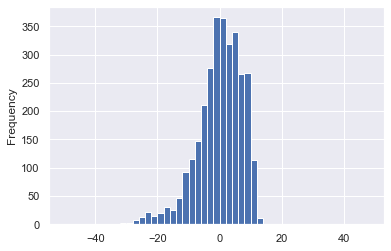

In [197]:
(error-error.mean()).plot(kind='hist', bins = range(-50,50,2))

In [198]:
(error-error.mean()).mean()

-1.5548319747728332e-14